In [116]:
import os, json
import numpy as np
import torch.optim as optim
import torch.nn as nn
from qiskit.providers.fake_provider import FakeLima
from scripts.data_setup import load_data
from scripts.from_circ_to_numpy import operations_to_features, save_to_json, load_from_json
from scripts.model import create_models, train_and_test_step, save_models, load_models
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import BackendEstimator
from zne import zne, ZNEStrategy
from zne.noise_amplification import *
from zne.extrapolation import *
from qiskit_aer import AerSimulator
from sklearn.metrics import root_mean_squared_error
from utils import get_backend_properties_v1
import torch
from mlp import recursive_dict_loop, count_gates_by_rotation_angle
from torch.utils.data import Dataset, DataLoader, TensorDataset
import random
from scripts.model import *
from qiskit.compiler import transpile
from mitiq.benchmarks import generate_rb_circuits
from mitiq.zne import execute_with_zne
from mitiq.zne.scaling import (
    fold_gates_at_random,
    fold_global,
    fold_all
)
from mitiq.zne.inference import LinearFactory, RichardsonFactory
from mitiq import (
    Calibrator,
    Settings,
    execute_with_mitigation,
    MeasurementResult,
)

In [2]:
dir_models = 'experiments/test_2'
dir_data = 'data_small_1'

n_qubits = 5 # 5 == n_qubits, default value for now because of FakeLima
train_circuits, train_observables, train_ideal_exp_vals, train_noisy_exp_vals, test_circuits, test_observables, test_ideal_exp_vals, test_noisy_exp_vals = load_data(f'data/circuits/{dir_data}')
X_train, y_train, X_test, y_test = load_from_json(f'data/features/{dir_data}')

In [3]:
backend = FakeLima()
backend_noisy = AerSimulator.from_backend(backend)

In [110]:
def get_zne_expval(circ,
                   obs: str,
                   backend,
                   ) -> float:
    """Returns the zero-noise expectation values for a list of observables `obs` of a circuit `circ`
    Inputs:
    obs (list[str]): Observables in Endian convention (e.g. 'IIZ' is the Z operator on the 0th qubit) for the PHYSICAL qubits
    mapping (list[int]): Mapping between logical and physical qubits, e.g. mapping[0] is the physical qubit for logical qubit 0
    """
    ## Build ZNEEstimator
    ZNEEstimator = zne(BackendEstimator)
    estimator = ZNEEstimator(backend=backend)

    observable = obs.primitive

    zne_strategy = ZNEStrategy()

    job = estimator.run(circ, observable, zne_strategy=zne_strategy)
    result = job.result()

    return result.values[0]

In [111]:
zne_mitigated = []
for i, circ in enumerate(test_circuits):
    zne_mitigated.append(get_zne_expval(circ, test_observables[i], backend))

In [112]:
zne_rms_test = root_mean_squared_error(test_ideal_exp_vals, zne_mitigated)
print(zne_rms_test)

0.36726683713205366


In [67]:
properties = get_backend_properties_v1(backend=backend)

In [8]:
def encode_data(circuits, properties, ideal_exp_vals, noisy_exp_vals, num_qubits, meas_bases=None):
    # if isinstance(noisy_exp_vals[0], list) and len(noisy_exp_vals[0]) == 1:
    #     noisy_exp_vals = [x[0] for x in noisy_exp_vals]

    gates_set = sorted(properties['gates_set'])     # must sort!

    if meas_bases is None:
        meas_bases = [[]]

    vec = [np.mean(recursive_dict_loop(properties, out=[], target_key1='cx', target_key2='gate_error'))]
    vec += [np.mean(recursive_dict_loop(properties, out=[], target_key1='id', target_key2='gate_error'))]
    vec += [np.mean(recursive_dict_loop(properties, out=[], target_key1='sx', target_key2='gate_error'))]
    vec += [np.mean(recursive_dict_loop(properties, out=[], target_key1='x', target_key2='gate_error'))]
    vec += [np.mean(recursive_dict_loop(properties, out=[], target_key1='rz', target_key2='gate_error'))]
    vec += [np.mean(recursive_dict_loop(properties, out=[], target_key1='', target_key2='readout_error'))]
    vec += [np.mean(recursive_dict_loop(properties, out=[], target_key1='', target_key2='t1'))]
    vec += [np.mean(recursive_dict_loop(properties, out=[], target_key1='', target_key2='t2'))]
    vec = torch.tensor(vec) * 100  # put it in the same order of magnitude as the expectation values

    bin_size = 0.1 * np.pi
    num_angle_bins = int(np.ceil(4 * np.pi / bin_size))

    X = torch.zeros([len(circuits), len(vec) + len(gates_set) + num_angle_bins + num_qubits + len(meas_bases[0])])

    vec_slice = slice(0, len(vec))
    gate_counts_slice = slice(len(vec), len(vec)+len(gates_set))
    angle_bins_slice = slice(len(vec)+len(gates_set), len(vec)+len(gates_set)+num_angle_bins)
    exp_val_slice = slice(len(vec)+len(gates_set)+num_angle_bins, len(vec)+len(gates_set)+num_angle_bins+num_qubits)
    meas_basis_slice = slice(len(vec)+len(gates_set)+num_angle_bins+num_qubits, len(X[0]))

    X[:, vec_slice] = vec[None, :]

    for i, circ in enumerate(circuits):
        gate_counts_all = circ.count_ops()
        X[i, gate_counts_slice] = torch.tensor(
            [gate_counts_all.get(key, 0) for key in gates_set]
        ) * 0.01  # put it in the same order of magnitude as the expectation values

    for i, circ in enumerate(circuits):
        gate_counts = count_gates_by_rotation_angle(circ, bin_size)
        X[i, angle_bins_slice] = torch.tensor(gate_counts) * 0.01  # put it in the same order of magnitude as the expectation values

        # if num_qubits > 1: assert len(noisy_exp_vals[i]) == num_qubits
        # elif num_qubits == 1: assert isinstance(noisy_exp_vals[i], float)

        X[i, exp_val_slice] = torch.tensor(noisy_exp_vals[i])

    if meas_bases != [[]]:
        assert len(meas_bases) == len(circuits)
        for i, basis in enumerate(meas_bases):
            X[i, meas_basis_slice] = torch.tensor(basis)

    y = torch.tensor(ideal_exp_vals, dtype=torch.float32)

    return X, y

In [9]:
def fix_random_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'random seed fixed to {seed}')

In [10]:
X_train_rf, y_train_rf = encode_data(train_circuits, properties, train_ideal_exp_vals, train_noisy_exp_vals, num_qubits=n_qubits)
X_test_rf, y_test_rf = encode_data(test_circuits, properties, test_ideal_exp_vals, test_noisy_exp_vals, num_qubits=n_qubits)
BATCH_SIZE = 32
fix_random_seed(42)
train_dataset = TensorDataset(torch.Tensor(X_train_rf), torch.Tensor(y_train_rf))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(torch.Tensor(X_test_rf), torch.Tensor(y_test_rf))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*1000, shuffle=False)

random seed fixed to 42


In [11]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
rfr = RandomForestRegressor(n_estimators=300)
rfr.fit(X_train_rf, y_train_rf)

RandomForestRegressor(n_estimators=300)

In [12]:
import os
import torch

def load_best_sequence_ann_model(model_dir):
    models = os.listdir(model_dir)
    min_rmse = float('inf')
    best_sequence_model = None
    best_ann = None

    for model in models:
        sequence_model_path = os.path.join(model_dir, model, 'sequence_model.pth')
        ann_path = os.path.join(model_dir, model, 'ann.pth')
        sequence_config_path = os.path.join(model_dir, model, 'sequence_config.json')
        ann_config_path = os.path.join(model_dir, model, 'ann_config.json')

        with open(sequence_config_path, "r") as f:
            sequence_config = json.load(f)

        with open(ann_config_path, "r") as f:
            ann_config = json.load(f)

        sequence_model = SequenceModel(input_size=sequence_config["input_size"],
                                       hidden_size=sequence_config["hidden_size"],
                                       num_layers=sequence_config["num_layers"],
                                       model_type=sequence_config["model_type"],
                                       p_dropout=sequence_config["dropout"])

        ann = ANN(input_shape=sequence_config["hidden_size"] * 5 + 1 if ann_config["noisy_first"] else sequence_config["hidden_size"] * 5,
                  hidden_units=ann_config["hidden_units"],
                  hidden_layers=ann_config["hidden_layers"],
                  output_shape=1,
                  p_drouput=ann_config["dropout"],
                  noisy_first=ann_config["noisy_first"])

        sequence_model.load_state_dict(torch.load(sequence_model_path))
        ann.load_state_dict(torch.load(ann_path))

        test_loss = test_step(sequence_model=sequence_model,
                              ann=ann,
                              loss_fn=nn.MSELoss(),
                              X=X_test,
                              noisy_exp_vals=test_noisy_exp_vals,
                              y=y_test,
                              noisy_first=ann_config["noisy_first"])

        if test_loss < min_rmse:
            min_rmse = test_loss
            best_sequence_model = sequence_model
            best_ann = ann

    return best_sequence_model, best_ann

best_sequence_model, best_ann = load_best_sequence_ann_model('experiments/test_2/models')


c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but

In [13]:
best_sequence_model

SequenceModel(
  (qubit_models): ModuleDict(
    (sequence_0): LSTM(7, 2, num_layers=4, batch_first=True)
    (sequence_1): LSTM(7, 2, num_layers=4, batch_first=True)
    (sequence_2): LSTM(7, 2, num_layers=4, batch_first=True)
    (sequence_3): LSTM(7, 2, num_layers=4, batch_first=True)
    (sequence_4): LSTM(7, 2, num_layers=4, batch_first=True)
  )
)

In [14]:
best_ann

ANN(
  (layers): ModuleDict(
    (input): Linear(in_features=11, out_features=64, bias=True)
    (hidden0): Linear(in_features=64, out_features=64, bias=True)
    (hidden1): Linear(in_features=64, out_features=64, bias=True)
    (output): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [15]:
from sklearn.metrics import mean_squared_error
import numpy as np

def get_model_predictions(sequence_model, ann, rfr, X_test_rf, X_test, test_noisy_exp_vals, noisy_first, zne_mitigated):
    sequence_ann_preds = []
    for i in range(len(X_test)):
        sequence_ann_preds.append(run_models(sequence_model, ann, X_test[i], test_noisy_exp_vals[i], noisy_first).detach().cpu().numpy())

    rfr_preds = rfr.predict(X_test_rf)

    zne_preds = zne_mitigated

    return sequence_ann_preds, rfr_preds, zne_preds

sequence_ann_preds, rfr_preds, zne_preds = get_model_predictions(best_sequence_model, best_ann, rfr, X_test_rf, X_test, test_noisy_exp_vals, best_ann.noisy_first, zne_mitigated)


In [128]:
def calculate_rmse_per_circuit(sequence_ann_preds, rfr_preds, zne_preds, y_test):
    rmse_sequence_ann = []
    rmse_rfr = []
    rmse_zne = []

    for i in range(len(y_test)):
        rmse_sequence_ann.append(np.sqrt(mean_squared_error([y_test[i]], [sequence_ann_preds[i]])))
        rmse_rfr.append(np.sqrt(mean_squared_error([y_test[i]], [rfr_preds[i]])))
        rmse_zne.append(np.sqrt(mean_squared_error([y_test[i]], [zne_preds[i]])))

    return rmse_sequence_ann, rmse_rfr, rmse_zne

rmse_sequence_ann, rmse_rfr, rmse_zne = calculate_rmse_per_circuit(sequence_ann_preds, rfr_preds, zne_preds, y_test_rf)



In [17]:
circ_depth = [transpile(circ, optimization_level=0, backend=backend).depth() for circ in test_circuits]

{'red': 'Sequence+ANN', 'blue': 'RF paper', 'green': 'ZNE'}


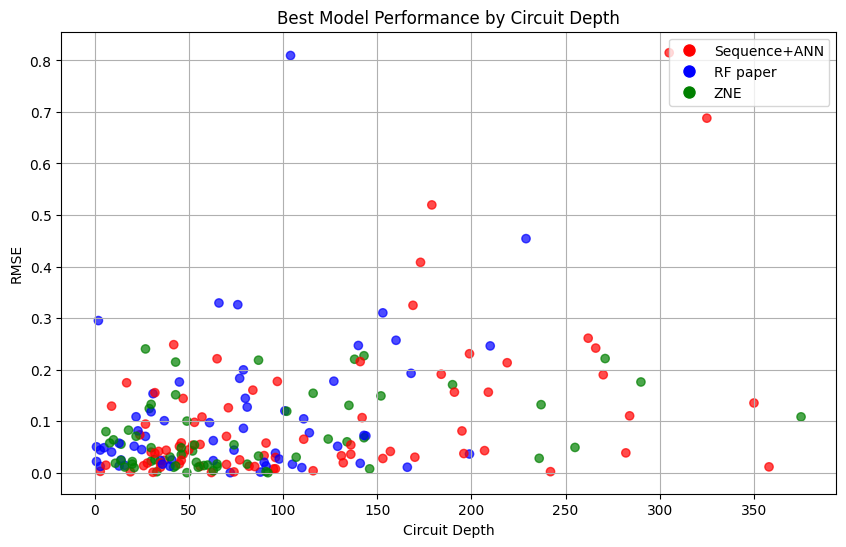

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_best_model_performance(rmse_sequence_ann, rmse_rfr, rmse_zne, circuit_depths):
    best_model_indices = np.argmin([rmse_sequence_ann, rmse_rfr, rmse_zne], axis=0)
    color_map = {0: 'red', 1: 'blue', 2: 'green'}
    labels_default = {0: 'Sequence+ANN', 1: 'RF paper', 2: 'ZNE'}

    colors = [color_map[idx] for idx in best_model_indices]

    plt.figure(figsize=(10, 6))
    plt.scatter(circuit_depths, np.min([rmse_sequence_ann, rmse_rfr, rmse_zne], axis=0), c=colors, alpha=0.7)

    legend_labels = {color: label for color, label in zip(color_map.values(), labels_default.values())}
    print(legend_labels)
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_labels.keys()]
    plt.legend(handles, legend_labels.values())

    plt.xlabel('Circuit Depth')
    plt.ylabel('RMSE')
    plt.title('Best Model Performance by Circuit Depth')
    plt.grid(True)
    plt.show()

plot_best_model_performance(rmse_sequence_ann, rmse_rfr, rmse_zne, circ_depth)

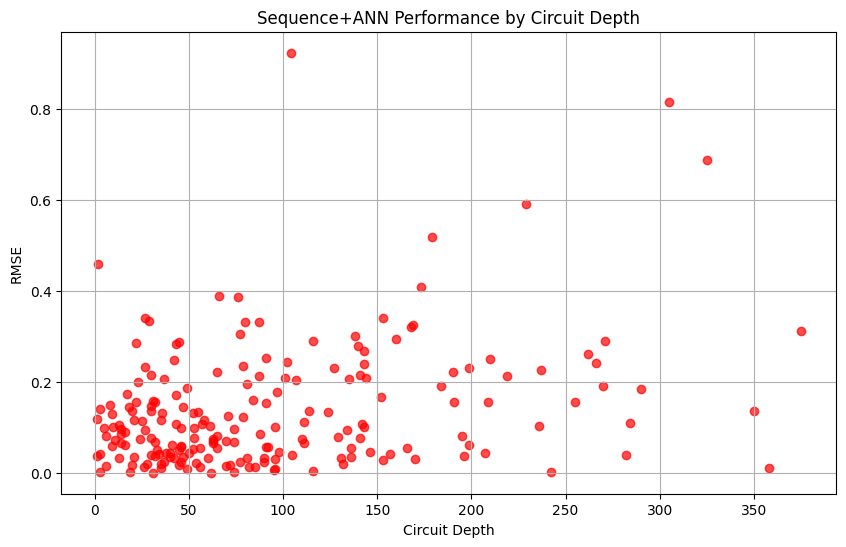

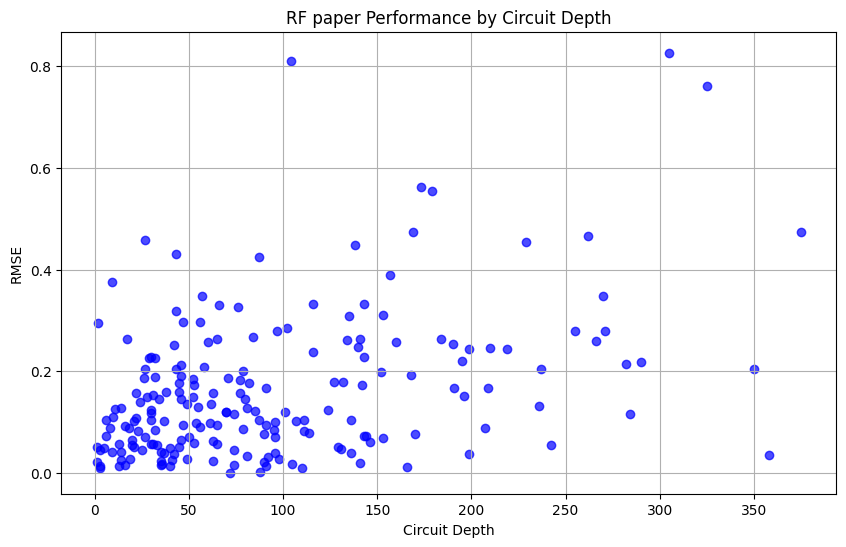

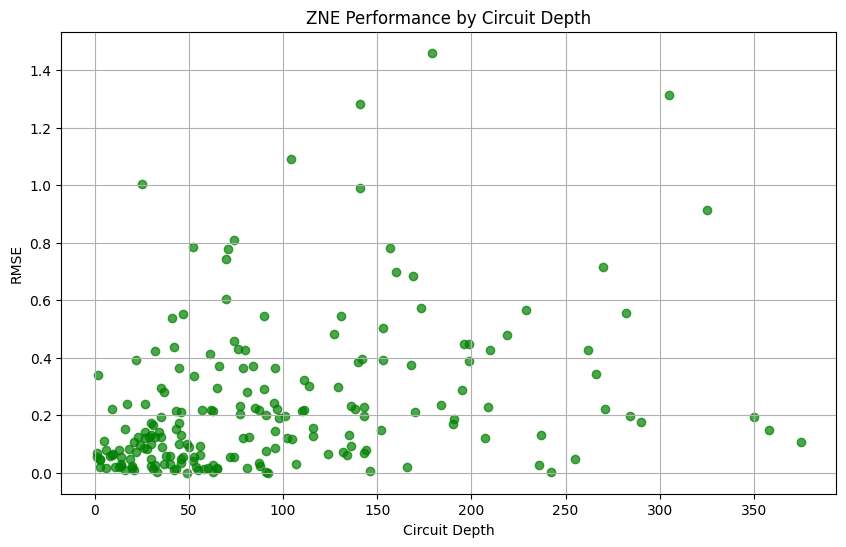

In [19]:
import matplotlib.pyplot as plt
import numpy as np


def plot_model_performance(rmse, circuit_depths, model_name, color):
    plt.figure(figsize=(10, 6))
    plt.scatter(circuit_depths, rmse, c=color, alpha=0.7)
    plt.xlabel('Circuit Depth')
    plt.ylabel('RMSE')
    plt.title(f'{model_name} Performance by Circuit Depth')
    plt.grid(True)
    plt.show()

plot_model_performance(rmse_sequence_ann, circ_depth, 'Sequence+ANN', 'red')
plot_model_performance(rmse_rfr, circ_depth, 'RF paper', 'blue')
plot_model_performance(rmse_zne, circ_depth, 'ZNE', 'green')


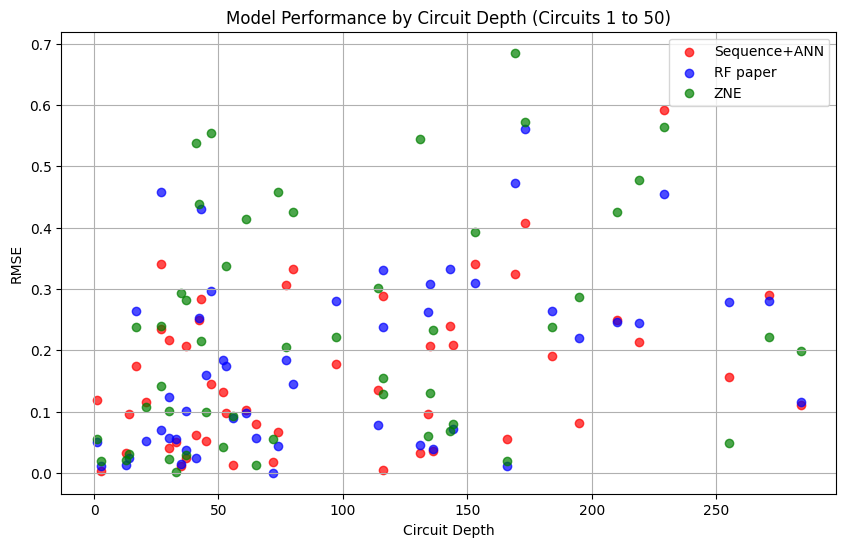

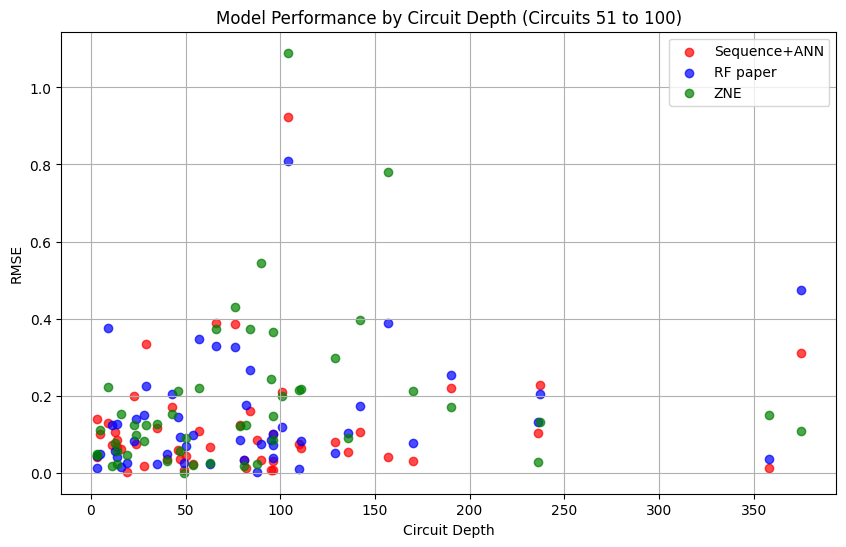

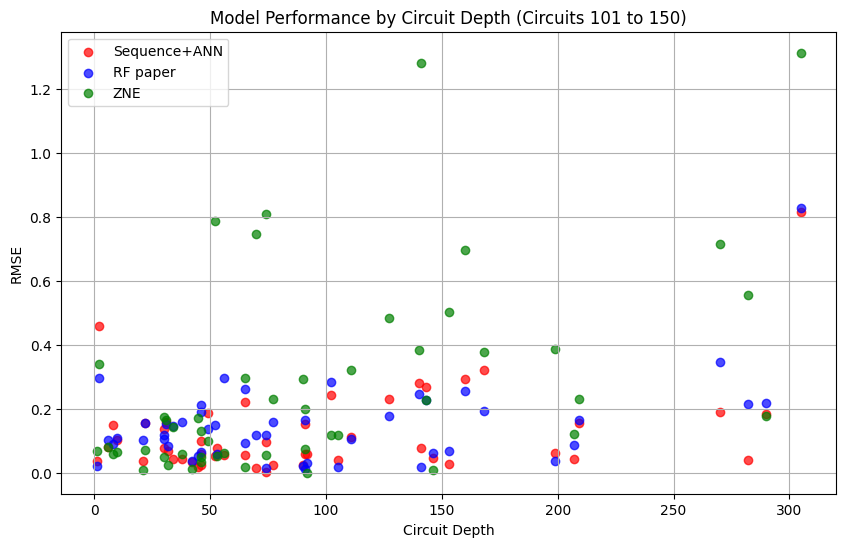

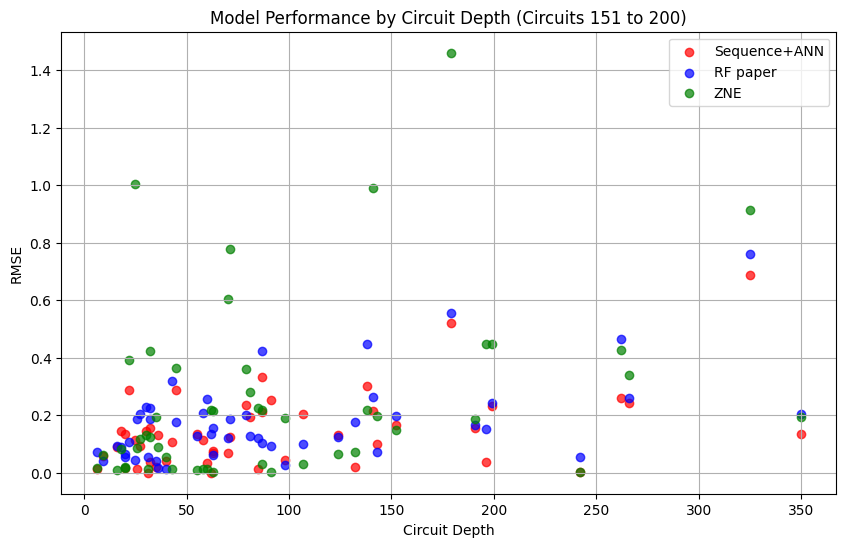

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_combined_model_performance(rmse_sequence_ann, rmse_rfr, rmse_zne, circuit_depths, start_idx, end_idx):
    subset_circuit_depths = circuit_depths[start_idx:end_idx]
    subset_rmse_sequence_ann = rmse_sequence_ann[start_idx:end_idx]
    subset_rmse_rfr = rmse_rfr[start_idx:end_idx]
    subset_rmse_zne = rmse_zne[start_idx:end_idx]

    plt.figure(figsize=(10, 6))
    plt.scatter(subset_circuit_depths, subset_rmse_sequence_ann, c='red', label='Sequence+ANN', alpha=0.7)
    plt.scatter(subset_circuit_depths, subset_rmse_rfr, c='blue', label='RF paper', alpha=0.7)
    plt.scatter(subset_circuit_depths, subset_rmse_zne, c='green', label='ZNE', alpha=0.7)
    
    plt.xlabel('Circuit Depth')
    plt.ylabel('RMSE')
    plt.title(f'Model Performance by Circuit Depth (Circuits {start_idx+1} to {end_idx})')
    plt.legend()
    plt.grid(True)
    plt.show()

num_circuits_per_plot = 50

total_circuits = len(circ_depth)

num_plots = total_circuits // num_circuits_per_plot + (total_circuits % num_circuits_per_plot > 0)

for i in range(num_plots):
    start_idx = i * num_circuits_per_plot
    end_idx = min((i + 1) * num_circuits_per_plot, total_circuits)
    plot_combined_model_performance(rmse_sequence_ann, rmse_rfr, rmse_zne, circ_depth, start_idx, end_idx)


In [21]:
def print_circuit_details(rmse_sequence_ann, rmse_rfr, rmse_zne, circuit_depths, start_idx, end_idx):
    subset_circuit_depths = circuit_depths[start_idx:end_idx]
    subset_rmse_sequence_ann = rmse_sequence_ann[start_idx:end_idx]
    subset_rmse_rfr = rmse_rfr[start_idx:end_idx]
    subset_rmse_zne = rmse_zne[start_idx:end_idx]
    best_model_indices = np.argmin([subset_rmse_sequence_ann, subset_rmse_rfr, subset_rmse_zne], axis=0)

    model_names = {0: 'Sequence+ANN', 1: 'RF paper', 2: 'ZNE'}

    print(f"Details for Circuits {start_idx + 1} to {end_idx}:")
    for i, idx in enumerate(range(start_idx, end_idx)):
        best_model = model_names[best_model_indices[i]]
        print(f"Circuit {idx + 1} (Depth: {subset_circuit_depths[i]}):")
        print(f"  Best Model: {best_model}")
        print(f"  RMSE Sequence+ANN: {subset_rmse_sequence_ann[i]}")
        print(f"  RMSE RF paper: {subset_rmse_rfr[i]}")
        print(f"  RMSE ZNE: {subset_rmse_zne[i]}")
        print()

num_circuits_per_print = 50

total_circuits = len(circ_depth)

num_prints = total_circuits // num_circuits_per_print + (total_circuits % num_circuits_per_print > 0)

for i in range(num_prints):
    start_idx = i * num_circuits_per_print
    end_idx = min((i + 1) * num_circuits_per_print, total_circuits)
    print_circuit_details(rmse_sequence_ann, rmse_rfr, rmse_zne, circ_depth, start_idx, end_idx)


Details for Circuits 1 to 50:
Circuit 1 (Depth: 116):
  Best Model: ZNE
  RMSE Sequence+ANN: 0.2892996072769165
  RMSE RF paper: 0.2376953125000001
  RMSE ZNE: 0.15432500000000005

Circuit 2 (Depth: 271):
  Best Model: ZNE
  RMSE Sequence+ANN: 0.29056647419929504
  RMSE RF paper: 0.27953125
  RMSE ZNE: 0.221646875

Circuit 3 (Depth: 80):
  Best Model: RF paper
  RMSE Sequence+ANN: 0.3321259021759033
  RMSE RF paper: 0.14451171875000002
  RMSE ZNE: 0.42628125000000017

Circuit 4 (Depth: 74):
  Best Model: RF paper
  RMSE Sequence+ANN: 0.06705092638731003
  RMSE RF paper: 0.04402604166666668
  RMSE ZNE: 0.4589531250000001

Circuit 5 (Depth: 56):
  Best Model: Sequence+ANN
  RMSE Sequence+ANN: 0.01265639066696167
  RMSE RF paper: 0.09012369791666663
  RMSE ZNE: 0.09261562500000009

Circuit 6 (Depth: 13):
  Best Model: RF paper
  RMSE Sequence+ANN: 0.0325312614440918
  RMSE RF paper: 0.013216145833333304
  RMSE ZNE: 0.021612500000000034

Circuit 7 (Depth: 144):
  Best Model: RF paper
  RMS

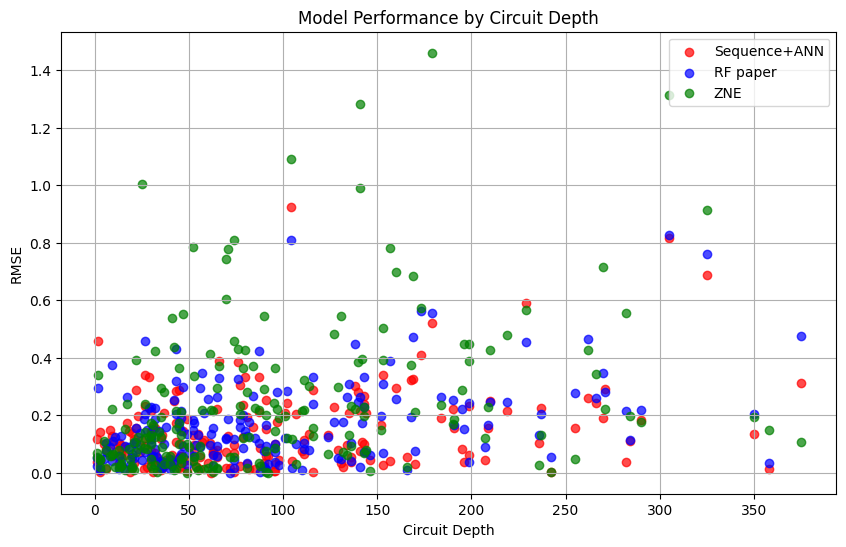

Best Model Distribution:
  Sequence+ANN: 79 circuits
  RF paper: 60 circuits
  ZNE: 61 circuits

Average RMSE Values:
  Sequence+ANN: 0.13736991584300995
  RF paper: 0.16087996341765873
  ZNE: 0.23308700000000002


c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


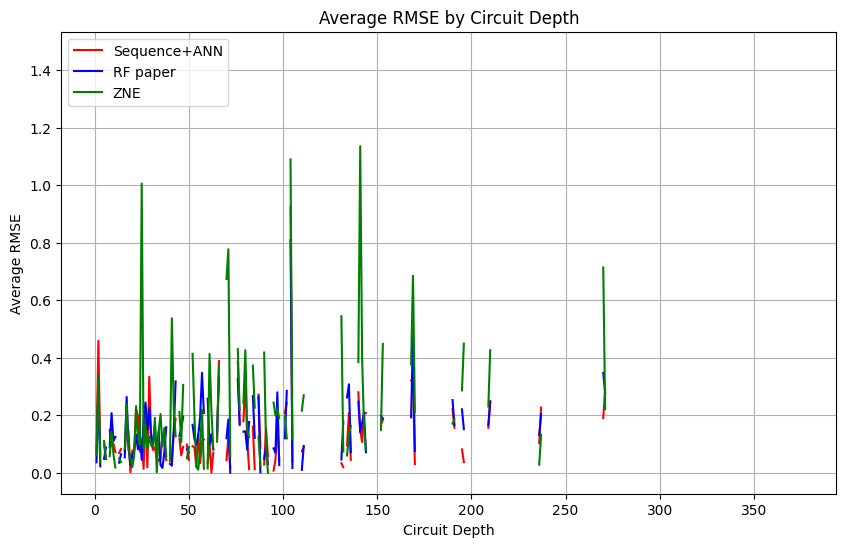

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_and_plot_performance(rmse_sequence_ann, rmse_rfr, rmse_zne, circuit_depths):
    best_model_indices = np.argmin([rmse_sequence_ann, rmse_rfr, rmse_zne], axis=0)
    color_map = {0: 'red', 1: 'blue', 2: 'green'}
    labels = {0: 'Sequence+ANN', 1: 'RF paper', 2: 'ZNE'}
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(circuit_depths, rmse_sequence_ann, color='red', alpha=0.7, label='Sequence+ANN')
    plt.scatter(circuit_depths, rmse_rfr, color='blue', alpha=0.7, label='RF paper')
    plt.scatter(circuit_depths, rmse_zne, color='green', alpha=0.7, label='ZNE')
    plt.xlabel('Circuit Depth')
    plt.ylabel('RMSE')
    plt.title('Model Performance by Circuit Depth')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Analysis
    results = []
    for i in range(len(circuit_depths)):
        best_model = labels[best_model_indices[i]]
        depth = circuit_depths[i]
        rmse_values = {
            'Sequence+ANN': rmse_sequence_ann[i],
            'RF paper': rmse_rfr[i],
            'ZNE': rmse_zne[i]
        }
        results.append((i, best_model, depth, rmse_values))
    
    # Best model distribution
    model_counts = {model: 0 for model in labels.values()}
    for best_model in best_model_indices:
        model_counts[labels[best_model]] += 1
    print("Best Model Distribution:")
    for model, count in model_counts.items():
        print(f"  {model}: {count} circuits")
    
    # RMSE comparisons
    avg_rmse_sequence_ann = np.mean(rmse_sequence_ann)
    avg_rmse_rfr = np.mean(rmse_rfr)
    avg_rmse_zne = np.mean(rmse_zne)
    print("\nAverage RMSE Values:")
    print(f"  Sequence+ANN: {avg_rmse_sequence_ann}")
    print(f"  RF paper: {avg_rmse_rfr}")
    print(f"  ZNE: {avg_rmse_zne}")
    
    # Performance trends
    depth_range = np.arange(min(circuit_depths), max(circuit_depths) + 1)
    avg_rmse_per_depth_sequence_ann = [np.mean([rmse_sequence_ann[i] for i in range(len(circuit_depths)) if circuit_depths[i] == depth]) for depth in depth_range]
    avg_rmse_per_depth_rfr = [np.mean([rmse_rfr[i] for i in range(len(circuit_depths)) if circuit_depths[i] == depth]) for depth in depth_range]
    avg_rmse_per_depth_zne = [np.mean([rmse_zne[i] for i in range(len(circuit_depths)) if circuit_depths[i] == depth]) for depth in depth_range]

    plt.figure(figsize=(10, 6))
    plt.plot(depth_range, avg_rmse_per_depth_sequence_ann, color='red', label='Sequence+ANN')
    plt.plot(depth_range, avg_rmse_per_depth_rfr, color='blue', label='RF paper')
    plt.plot(depth_range, avg_rmse_per_depth_zne, color='green', label='ZNE')
    plt.xlabel('Circuit Depth')
    plt.ylabel('Average RMSE')
    plt.title('Average RMSE by Circuit Depth')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Call the function with the provided data
analyze_and_plot_performance(rmse_sequence_ann, rmse_rfr, rmse_zne, circ_depth)


In [23]:
rfr_rms = root_mean_squared_error(y_test_rf, y_pred=rfr.predict(X_test_rf))
print(rfr_rms)

0.21440823527288264


In [24]:
sequence_ann_rmse = test_step(best_sequence_model, best_ann, nn.MSELoss(), X_test, test_noisy_exp_vals, y_test, True)
print(sequence_ann_rmse)

0.19352911


In [53]:
zne_rmse = root_mean_squared_error(test_ideal_exp_vals, zne_mitigated)
print(zne_rmse)

0.35241126326547395


In [121]:
unmitigated_rmse = root_mean_squared_error(test_ideal_exp_vals, test_noisy_exp_vals)
print(unmitigated_rmse)

0.23184897716330327


In [126]:
rmse_unmitigated = []

for i in range(len(y_test)):
    rmse_unmitigated.append(np.sqrt(mean_squared_error([test_noisy_exp_vals[i]], [test_ideal_exp_vals[i]])))

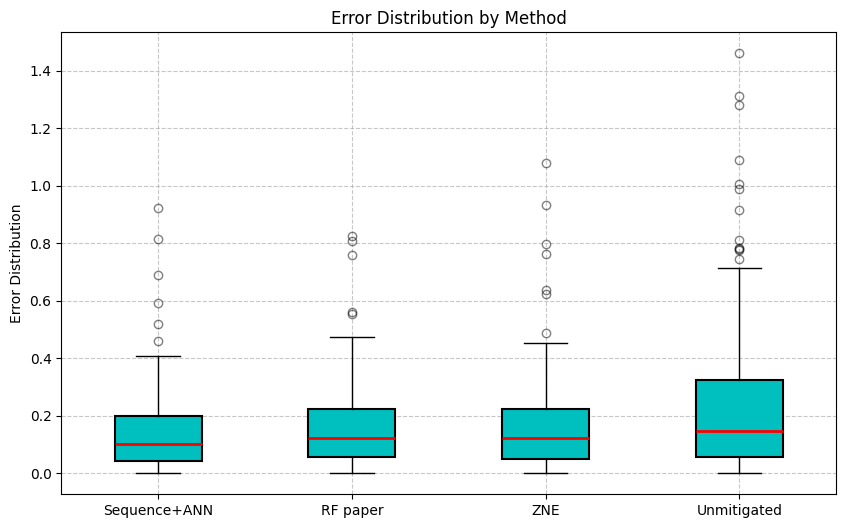

In [129]:
# Combine all data into a list of lists
data = [rmse_sequence_ann, rmse_rfr, rmse_unmitigated, rmse_zne]

# Create the box plot
plt.figure(figsize=(10, 6))
boxprops = dict(facecolor='c', color='black', linewidth=1.5)
medianprops = dict(color='red', linewidth=2)
flierprops = dict(marker='o', color='black', alpha=0.5)

plt.boxplot(data, patch_artist=True, boxprops=boxprops, 
            medianprops=medianprops, flierprops=flierprops)

# Customizing the plot
plt.xticks([1, 2, 3, 4], ['Sequence+ANN', 'RF paper', 'ZNE', 'Unmitigated'])
plt.ylabel('Error Distribution')
plt.title('Error Distribution by Method')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()